In [0]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# 'cs231n' folder containing the '.py', 'classifiers' and 'datasets'
# folders.
# e.g. 'cs231n/assignments/assignment1/cs231n/'
FOLDERNAME = 'cs231n/assignments/assignment1/cs231n/'

# symlink to make it easier to load your files
!ln -s "/content/drive/My Drive/$FOLDERNAME" "/content/assignment1"

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../
%cd ../../
%cd cs231n/datasets/
!bash get_datasets.sh
%cd ../../

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive
/content
/content/cs231n/datasets
--2020-04-19 08:01:51--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>

# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [0]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [0]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [0]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [0]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-7, 1e-5, 1e-3]
regularization_strengths = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# permute over learning_rates and regularization_strengths
grid_search = [(lr, reg) for lr in learning_rates \
               for reg in regularization_strengths]

for config_num, config in enumerate(grid_search):
    print("Hyperparam config #{} of #{}".format(config_num+1, len(grid_search)))
    print("Hyperparam config: {}".format(config))
    lr, reg = config

    svm = LinearSVM()

    # train a linear SVM on the training set
    loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, 
                          reg=reg, num_iters=2000, verbose=False)

    # make predictions on the training and validation sets
    y_train_pred = svm.predict(X_train_feats)
    y_val_pred = svm.predict(X_val_feats)

    # compute the accuracy on the training and validation sets
    current_y_train_accuracy = np.mean(y_train_pred == y_train)
    current_y_val_accuracy = np.mean(y_val_pred == y_val)

    # store results
    results[(lr, reg)] = (current_y_train_accuracy, current_y_val_accuracy)

    # store the best validation accuracy and the LinearSVM object
    if current_y_val_accuracy > best_val: 
        best_val = current_y_val_accuracy
        best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

Hyperparam config #1 of #36
Hyperparam config: (1e-09, 0.01)
Hyperparam config #2 of #36
Hyperparam config: (1e-09, 0.05)
Hyperparam config #3 of #36
Hyperparam config: (1e-09, 0.1)
Hyperparam config #4 of #36
Hyperparam config: (1e-09, 0.2)
Hyperparam config #5 of #36
Hyperparam config: (1e-09, 0.3)
Hyperparam config #6 of #36
Hyperparam config: (1e-09, 0.4)
Hyperparam config #7 of #36
Hyperparam config: (1e-09, 0.5)
Hyperparam config #8 of #36
Hyperparam config: (1e-09, 0.6)
Hyperparam config #9 of #36
Hyperparam config: (1e-09, 0.7)
Hyperparam config #10 of #36
Hyperparam config: (1e-07, 0.01)
Hyperparam config #11 of #36
Hyperparam config: (1e-07, 0.05)
Hyperparam config #12 of #36
Hyperparam config: (1e-07, 0.1)
Hyperparam config #13 of #36
Hyperparam config: (1e-07, 0.2)
Hyperparam config #14 of #36
Hyperparam config: (1e-07, 0.3)
Hyperparam config #15 of #36
Hyperparam config: (1e-07, 0.4)
Hyperparam config #16 of #36
Hyperparam config: (1e-07, 0.5)
Hyperparam config #17 of #36


In [0]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.475


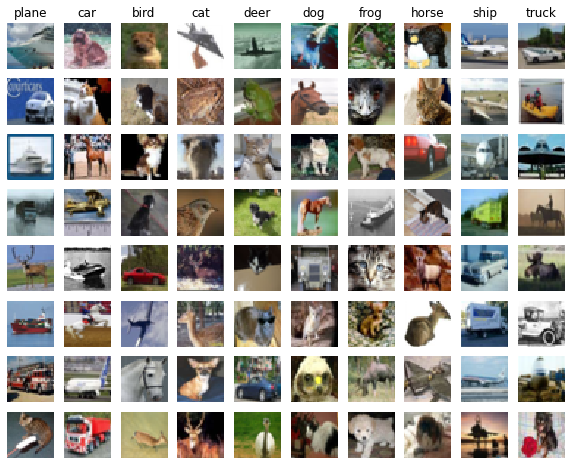

In [0]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

$\color{blue}{\textit Your Answer:}$ 

- Yes. For instance, an occasional sample of a cat, dog or even a car features in the bird class and vice versa. Cats, dogs, birds and other animals have similar "appearance" in that they have similar textures due to common facial features (eyes, ears, nose, mouth) and in some cases, quadruped legs, which HOG captures; they also have similar color schemes, which the color histogram represents. Similarly, horses and deers are mixed-up owing to similar textures and color features. Cars and trucks are mixed-up based on a similar argument. There are several class mismatches due to the background similarites as well - for instance, consider the plane class where the misclassified examples have similarities in the background because the sky and sea colors are similar, which is why they are commonly mixed up with ship images.

- In conclusion, the combination of HOG and color histogram feature vectors are not enough to distinguish between these classes with impeccable accuracy. The HOG descriptor is useful because it takes into account textures within an image, but HOG does not take into account types of intra-class variance such as rotation, scaling, translation, illumination, posture deformation etc. 

- Scale-invariant feature transform (SIFT) by Lowe can help improve the accuracy of our model in such scenarios. Color histogram features help discriminating classes on the basis of color schemes. We can weigh color histograms lower when using them in conjuction with more advanced feature descriptors like HOG or SIFT to reduce the problem of simple color-based class segregation.



## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [0]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [0]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# generate random combinations of hyperparameters given arrays of potential values
def random_hyperparams_search(lr_values, reg_values, hidden_size_values, epoch_values):
    lr = lr_values[np.random.randint(0, len(lr_values))]
    reg = reg_values[np.random.randint(0, len(reg_values))]
    hidden_size = hidden_size_values[np.random.randint(0, len(hidden_size_values))]
    epochs = epoch_values[np.random.randint(0, len(epoch_values))]
    return lr, reg, hidden_size, epochs

# number of hypercombinations combinations to look for
num_hyperparam_configs = 30

# randomly permute over learning_rate, regularization_strength, hidden_layer_size and num_training_epochs
grid_search = [random_hyperparams_search([3e-1, 2e-1, 1e-1, 1e-2, 1e-3], [2e-7, 1e-7, 1e-6, 1e-5], [30, 50, 80, 100, 150, 200], [3000, 5000])
               for count in range(num_hyperparam_configs)]

best_val = -1   # The highest validation accuracy that we have seen so far.
results = {}

for config_num, config in enumerate(grid_search):
    print("Hyperparam config #{} of #{}".format(config_num+1, len(grid_search)))
    print("Hyperparam config: {}".format(config))

    lr, reg, hidden_size, epochs = config

    net = TwoLayerNet(input_dim, hidden_size, num_classes)

    # train a 2-layer neural net on the training set
    loss_hist = net.train(X_train_feats, y_train, X_val_feats, y_val, 
                          learning_rate=lr, reg=reg, num_iters=epochs, 
                          batch_size=200, verbose=False)
    
    # make predictions on the training and validation sets
    y_train_pred = net.predict(X_train_feats)
    y_val_pred = net.predict(X_val_feats)
    
    # compute the accuracy on the training and validation sets
    current_y_train_accuracy = np.mean(y_train_pred == y_train)
    current_y_val_accuracy = np.mean(y_val_pred == y_val)
    
    # store results
    results[(lr, reg, hidden_size, epochs)] = \
            (current_y_train_accuracy, current_y_val_accuracy)
    
    # store the best validation accuracy and the TwoLayerNet object
    if current_y_val_accuracy > best_val: 
        best_val = current_y_val_accuracy
        best_net = net

# Print out results.
for lr, reg, hidden_size, num_training_epochs in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg, hidden_size, num_training_epochs)]
    print('lr %e reg %e hidden_size %e num_training_epochs %e train accuracy: %f val accuracy: %f' % (
           lr, reg, hidden_size, num_training_epochs, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


Hyperparam config #1 of #30
Hyperparam config: (0.001, 1e-06, 80, 5000)
Hyperparam config #2 of #30
Hyperparam config: (0.1, 1e-06, 100, 3000)
Hyperparam config #3 of #30
Hyperparam config: (0.1, 1e-07, 200, 5000)
Hyperparam config #4 of #30
Hyperparam config: (0.01, 2e-07, 200, 5000)
Hyperparam config #5 of #30
Hyperparam config: (0.2, 1e-05, 200, 3000)
Hyperparam config #6 of #30
Hyperparam config: (0.2, 1e-07, 150, 3000)
Hyperparam config #7 of #30
Hyperparam config: (0.01, 1e-05, 150, 3000)
Hyperparam config #8 of #30
Hyperparam config: (0.001, 1e-06, 80, 3000)
Hyperparam config #9 of #30
Hyperparam config: (0.3, 2e-07, 150, 3000)
Hyperparam config #10 of #30
Hyperparam config: (0.001, 1e-06, 80, 5000)
Hyperparam config #11 of #30
Hyperparam config: (0.001, 1e-07, 200, 5000)
Hyperparam config #12 of #30
Hyperparam config: (0.001, 1e-07, 50, 3000)
Hyperparam config #13 of #30
Hyperparam config: (0.001, 2e-07, 100, 5000)
Hyperparam config #14 of #30
Hyperparam config: (0.001, 2e-07, 

In [0]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.579


---
# IMPORTANT

This is the end of this question. Please do the following:

1. Click `File -> Save` to make sure the latest checkpoint of this notebook is saved to your Drive.
2. Execute the cell below to download the modified `.py` files back to your drive.

In [0]:
import os

FOLDER_TO_SAVE = os.path.join('drive/My Drive/', FOLDERNAME)
FILES_TO_SAVE = []

for files in FILES_TO_SAVE:
  with open(os.path.join(FOLDER_TO_SAVE, '/'.join(files.split('/')[1:])), 'w') as f:
    f.write(''.join(open(files).readlines()))